# Extreme Land Surface Temperature over Bordeaux - France

This Jupyter Notebook demonstrates how to quantify heatwave over cities based on the [Land Surface Temperature](https://docs.sentinel-hub.com/api/latest/data/planetary-variables/land-surface-temp/) product using the [Processing API](https://docs.sentinel-hub.com/api/latest/api/process/). This Notebook returns a time series from Sentinel Hub's API.

In this example, we retrieve the temperature anomalies based on the Land Surface Temperature Planetary Variable at 1km resolution going back to 2013 over Bordeaux, France. 

The anomaly of a variable is the variation relative to the climatological normal. The normal is the long-term average of the same variable and is used as a baseline value. The normal is typically computed by calculating a climatology over a long period (the climate normal period). A positive anomaly indicates that the observed temperature was warmer than the baseline, while a negative anomaly indicates that the observed temperature was cooler than the baseline.

In [25]:
import json
import pandas as pd
import numpy as np 
import getpass

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as mdates

from shapely.geometry import Polygon

from sentinelhub import (
    SHConfig,
    Geometry,
    CRS,
    SentinelHubStatistical,
    DataCollection,
    SentinelHubDownloadClient,
)

### Credentials

Process API requires Sentinel Hub account. Please check configuration instructions about how to set up your Sentinel Hub credentials in
the [readme](https://github.com/planetlabs/notebooks/tree/master?tab=readme-ov-file#sentinel-hub-python-sdk)

In [27]:
config = SHConfig()

if not config.sh_client_id or not config.sh_client_secret:
    print("No credentials found, please provide the OAuth client ID and secret.")
    config.sh_client_id = getpass.getpass("sh_client_id: ")
    config.sh_client_secret = getpass.getpass("sh_client_secret: ")
    config.save()
    print(f"Credentials saved to {SHConfig.get_config_location()}")
else:
    print(f"Using credentials stored here: {SHConfig.get_config_location()}")

Connected to Sentinel Hub


## Requesting Data from the Statistics API  

We build the request according to the [API Reference](https://docs.sentinel-hub.com/api/latest/api/process/), using the `SentinelHubStatistical` class from the `sentinelhub-py` [Python package](https://sentinelhub-py.readthedocs.io/en/latest/index.html).

### Set collection ID

The 1km [Land Surface Temperature](https://docs.sentinel-hub.com/api/latest/data/planetary-variables/land-surface-temp/) is available through the [Subscriptions API](https://developers.planet.com/docs/subscriptions/pvs-subs/). Once the area of interest and variables are subscribed to, the data can be automatically delivered into a Sentinel Hub collection if you use the [Sentinel Hub delivery option](https://developers.planet.com/docs/subscriptions/delivery/#delivery-to-sentinel-hub-collection). 

In this example, we will use the Land Surface Temperature collection available from [Planet Sandbox Data](https://collections.sentinel-hub.com/land-surface-temperature/sandbox-data.html). 

For more information on how to call a collection ID in a request with Python, you can refer to the `sentinelhub-py` [documentation](https://sentinelhub-py.readthedocs.io/en/latest/examples/byoc_request.html#Retrieve-data-from-collection).


In [37]:
collection_id = "6b613b07-410a-4312-93ad-d1751fdc55de"

data_collection = DataCollection.define_byoc(collection_id)

### Define an area of interest

Now, we define an area of interest: Bordeaux, France.

In [67]:
# Read a geojson containing a polygon representing the city of Bordeaux, France
with open("bordeaux.geojson") as file:
    bordeaux_json = json.load(file)

# Load GeoJSON into a shapely polygon
bordeaux_polgyon = Polygon(bordeaux_json["features"][0]["geometry"]["coordinates"][0][0])

# Convert shapely polygon to a Sentinel Hub geometry
bordeaux_aoi = Geometry(bordeaux_polgyon, crs=CRS(4326))

### Set the evalscript

Each Statistical API request also needs an [evalscript](https://docs.sentinel-hub.com/api/latest/evalscript/v3/).

Land Surface Temperature is available twice a day (at 1.30 and 13.30 solar local time), in this example we select the 13.30 sensing time (`sensing_time="1330"`) and convert the data to degree Celcius (the data is originally in Kelvin).

In [6]:
time_series_evalscript = """
//VERSION=3
sensing_time="1330"
function setup() {
    return {
        input: [{bands: ["LST", "dataMask"]}],
        output: [
            { id: "LST", bands: 1, sampleType: "FLOAT32" },
            { id: "dataMask", bands: 1, sampleType: "UINT8" }
        ],
        mosaicking: "TILE"
    };
}
// Filter out scenes where the sensing time matches specified sensing time
function preProcessScenes (collections) {
    collections.scenes.tiles = collections.scenes.tiles.filter(function (tile) {
        return tile.dataPath.includes("T"+sensing_time);
    })
    collections.scenes.tiles.sort((a, b) => new Date(b.date) - new Date(a.date));
    return collections
}
function evaluatePixel(samples) {
    var sample = samples[0].LST
    var nodata = samples[0].dataMask

    return {
        LST: [(sample/100)-273.15],
        dataMask: [nodata]
    };
}
"""

### Request the data 

We will extract the data with the following parameters:

* The Sandbox Data collection Land Surface Temperature (`data_collection`)
* January 1st, 2014 to December 31st, 2022
* At the native resolution (`0.01` degree -> ±1km)
* Using our previously defined evalscript (`time_series_evalscript`)
* Calculated for each day (`P1D`)
* Over the geometry of the city of Bordeaux (`bordeaux_aoi`) 

In [7]:
input_data = SentinelHubStatistical.input_data(data_collection)

# Specifiy your time of interest (TOI)
time_of_interest = "2014-01-01", "2022-12-31"

# Specify a resolution in degrees
resx = 0.01
resy = 0.01

# Use aggregation method to combine parameters
aggregation = SentinelHubStatistical.aggregation(
    evalscript=time_series_evalscript, time_interval=time_of_interest, aggregation_interval="P1D", resolution=(resx, resy)
)

# Create the request
request = SentinelHubStatistical(
        aggregation=aggregation,
        input_data=[input_data],
        geometry=bordeaux_aoi,
        config=config,
    )

In [11]:
# Post the requests
download_requests = [request.download_list[0]]
client = SentinelHubDownloadClient(config=config)
stats_response = client.download(download_requests)

### Format the time series
From the request, we will format the time series as a pandas DataFrame

In [28]:
series = pd.json_normalize(stats_response[0]["data"])
series['date'] = pd.to_datetime(series['interval.from'])
series.set_index('date', inplace=True)

series.head()

,interval.from,interval.to,outputs.LST.bands.B0.stats.min,outputs.LST.bands.B0.stats.max,outputs.LST.bands.B0.stats.mean,outputs.LST.bands.B0.stats.stDev,outputs.LST.bands.B0.stats.sampleCount,outputs.LST.bands.B0.stats.noDataCount
date,,,,,,,,
2014-01-01 00:00:00+00:00,2014-01-01T00:00:00Z,2014-01-02T00:00:00Z,8.71,11.06,9.524607,0.568492,238,60
2014-01-02 00:00:00+00:00,2014-01-02T00:00:00Z,2014-01-03T00:00:00Z,12.22,14.03,12.935955,0.458954,238,60
2014-01-03 00:00:00+00:00,2014-01-03T00:00:00Z,2014-01-04T00:00:00Z,11.58,13.06,12.031292,0.360655,238,60
2014-01-04 00:00:00+00:00,2014-01-04T00:00:00Z,2014-01-05T00:00:00Z,7.2,9.34,8.63264,0.50631,238,60
2014-01-05 00:00:00+00:00,2014-01-05T00:00:00Z,2014-01-06T00:00:00Z,9.19,10.06,9.451854,0.210044,238,60


## Compute Land Surface Temperature Anomaly

### Enrich the time series

To extract the anomaly, we will calculate: 
- 20 days rolling backward windows average: The rolling average, sometimes referred to as a moving average, is a metric that calculates trends over short periods of time. By considering the short trend in the Anomaly calculation, the results will focus on the persistent extreme temperatures. 
- climatology: Climatologies can be computed based on different terms. For this example, we will compute climatological averages, which are the mean for each day of the year over the specified period of time (2014-2022).
- Anomaly: The difference between the baseline (climatology) and the observations (20 days averaged in this example)

In [56]:
backward_average_window_size = 20
column = "outputs.LST.bands.B0.stats.mean"

# Fill missing dates
df = pd.DataFrame({"observation": series[column]})
continuous_dates = pd.date_range(start=df.index.min(), end=df.index.max())
df = df.reindex(continuous_dates)

#calculate the backward average
df["average"] = df["observation"].rolling(
    window=pd.Timedelta(days=backward_average_window_size), min_periods=1, center=False, closed=None
    ).mean()[backward_average_window_size - 1:]

# Calculate the climatology
df["doy"] = df.index.dayofyear
ser_per_doy = df.groupby("doy")["average"].agg("mean")
ser_per_doy.name = "climatology"
df = df.join(ser_per_doy, on="doy").drop(columns=["doy"])

#calculate the anomaly
df["anomaly"] = df["average"] - df["climatology"]

### Plot the results

In the next cell, we will plot the time series with the raw observations and the 20-day rolling average.

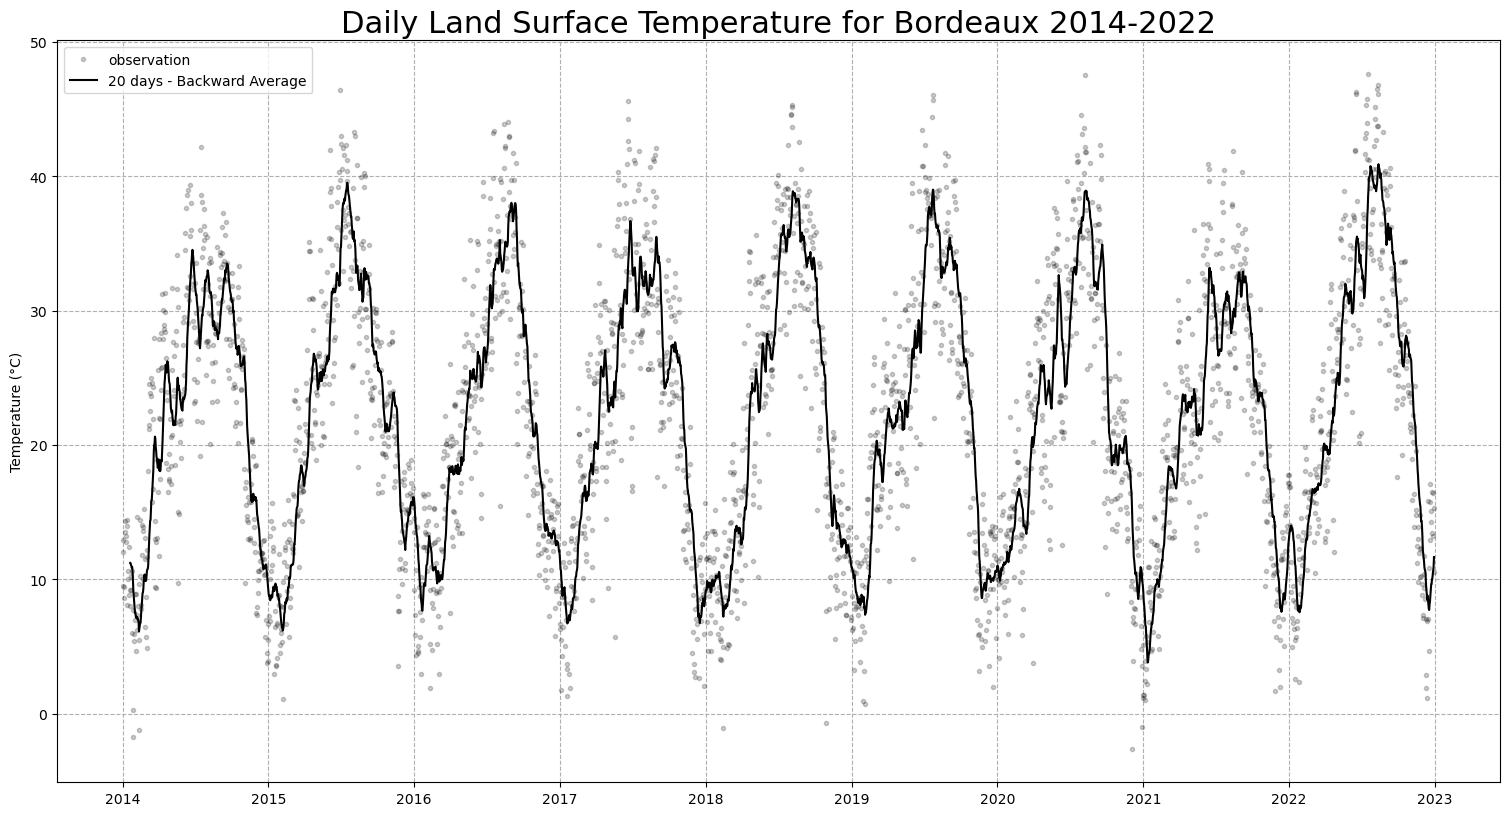

In [62]:
fig, ax = plt.subplots(1,1, figsize=(15, 8))
ax.plot(df["observation"], ".", color="black", alpha=0.2, label="observation")
ax.plot(df["average"], color="black", label=f"{backward_average_window_size} days - Backward Average")
ax.get_figure().tight_layout()
ax.grid(linestyle="--")
ax.legend()
ax.yaxis.set_label_text("Temperature (°C)")

plt.title('Daily Land Surface Temperature for Bordeaux 2014-2022', fontsize=22)
plt.show()

### Plot the anomaly time series

Finally, we will plot the anonaly on top of the time series from the 20 days rolling windows average. We will color the positive anomaly (warmer than normal condition) in red and the negetive anomaly (cooler than normal condition) in blue.

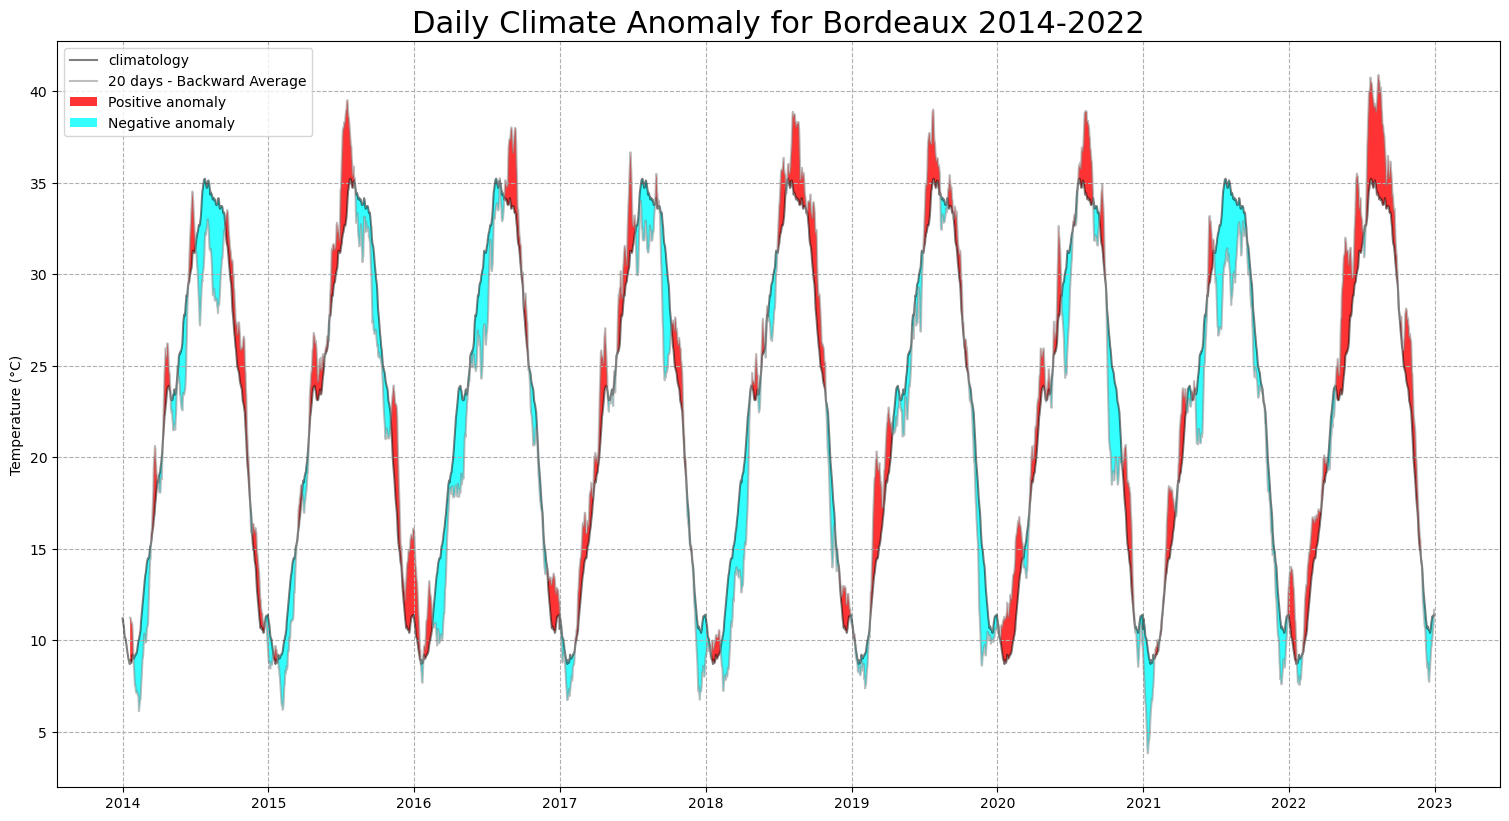

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.plot(df["climatology"], label="climatology", color="black", alpha=0.5)
ax.plot(df["average"], color="grey", alpha=0.5, label=f"{backward_average_window_size} days - Backward Average")

ax.fill_between(df.index.values, df["average"], df["climatology"], where=df["average"] >= df["climatology"],
                facecolor="red", alpha=0.8, interpolate=False, label="Positive anomaly")
ax.fill_between(df.index.values, df["average"], df["climatology"], where=df["climatology"] >= df["average"],
                facecolor="cyan", alpha=0.8, interpolate=False, label="Negative anomaly")

ax.get_figure().tight_layout()
ax.grid(linestyle="--")
ax.legend()
ax.yaxis.set_label_text("Temperature (°C)")

plt.title('Daily Climate Anomaly for Bordeaux 2014-2022', fontsize=22)
plt.show()

### Explore the evolution of positive anomaly for each year

The cumulative sum of positive anomalies in Land Surface Temperature is crucial for urban areas as it highlights periods of unusual warmth. This metric is useful for:

1. **Urban Heat Island Mitigation**: Helps city planners identify and address areas most affected by increased temperatures.
   
2. **Public Health**: Assists in preparing for and responding to heat waves, reducing heat-related illnesses.

3. **Infrastructure Planning**: Informs the design and placement of green spaces and cooling infrastructure to manage urban heat.

Overall, this metric supports sustainable urban development and enhances the resilience of cities to climate change.

In [64]:
df["year"] = df.index.year
df["doy"] = df.index.dayofyear
df["positive_cumsum"] = df.groupby("year")["anomaly"].apply(lambda x: x.where(x > 0, 0).cumsum()).reset_index(level=0, drop=True)

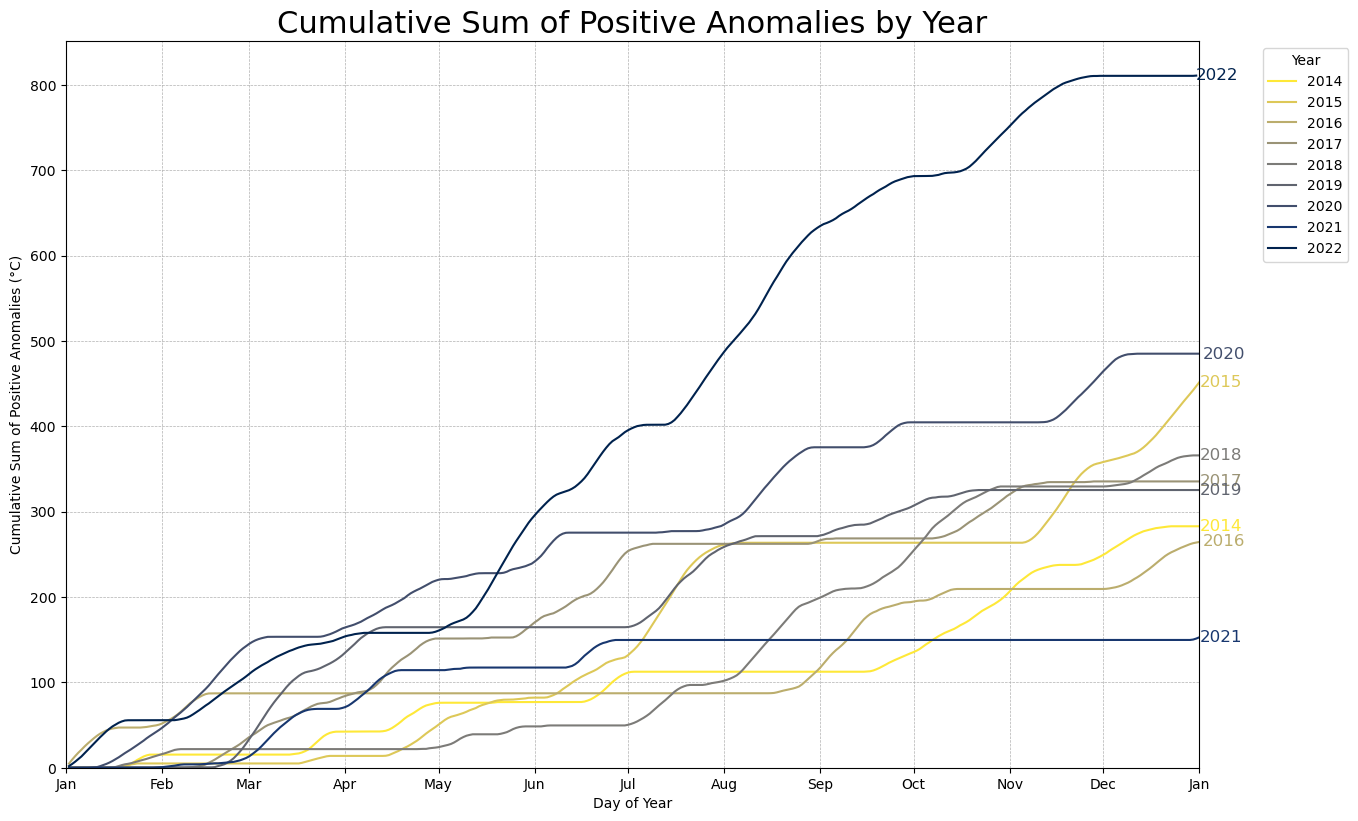

In [65]:
plt.figure(figsize=(12, 8))

# Plot each year with different colors
for year, color in zip(df["year"].unique(), cm.cividis_r(np.linspace(0, 1, len(df["year"].unique())))):
    df_subset = df[df["year"] == year].set_index("doy")["positive_cumsum"]
    df_subset.plot(color=color, label=year)
    plt.text(df_subset.index[-1], df_subset.iloc[-1], str(year), color=color, fontsize=12, va='center', ha='left')

# Set x-axis to show the first day of each month
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=1))
plt.gca().xaxis.set_minor_formatter(mdates.DateFormatter(''))

plt.tight_layout()
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Cumulative Sum of Positive Anomalies by Year', fontsize="22")
plt.xlabel('Day of Year')
plt.ylabel('Cumulative Sum of Positive Anomalies (°C)')
plt.xlim(0, 365)
plt.ylim(0)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()